# Table of Contents: <a class="anchor" id="contents"></a> 

* [Importing and cleaning data](#import)
* [Function Definitions](#funcdef)
    * [Recursive Feature Elimination (RFE) with Features and Target](#rfe)
    * [Cross Validated ROC Chart](#cvroc)
* [Target: HNHC](#hnhc)
    * [Logistic Regression RFE - HNHC](#lrhnhc)
    * [Decision Tree Classifier RFE - HNHC](#dtchnhc)
    * [XGBoost Classifier RFE](#xgbchnhc)
* [Target: HNHC without 'los'](#hnhcwolos)
    * [Logistic Regression RFE - HNHC](#lrhnhcwolos)
    * [Decision Tree Classifier RFE - HNHC](#dtchnhcwolos)
    * [XGBoost Classifier RFE](#xgbchnhcwolos)
* [Target: IBD_READM](#ibd)
    * [Logistic Regression RFE - HNHC](#lribd)
    * [Decision Tree Classifier RFE - HNHC](#dtcibd)
    * [XGBoost Classifier RFE](#xgbcibd)
* [Target: IBD_READM without 'los'](#ibdwolos)
    * [Logistic Regression RFE - HNHC](#lribdwolos)
    * [Decision Tree Classifier RFE - HNHC](#dtcibdwolos)
    * [XGBoost Classifier RFE](#xgbcibdwolos)

## Importing and cleaning data <a class="anchor" id="import"></a>

[Return to Table of Contents](#contents)

In [1]:
# Import dependencies
from sklearn import tree
from sklearn import metrics, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from numpy import interp
import os
import warnings
import timeit
import dask.dataframe as dd
from IPython.display import display 
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

In [2]:
# Read in the data as a dataframe.
df = pd.read_csv('NRD_2017_Defined_Cohort_Five_I10_DX.csv')
df.head()

,key_nrd,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,i10_dx1,i10_dx2,i10_dx3,i10_dx4,i10_dx5,i10_dx6,i10_dx7,i10_dx8,i10_dx9,i10_dx10,i10_dx11,i10_dx12,i10_dx13,i10_dx14,i10_dx15,i10_dx16,i10_dx17,i10_dx18,i10_dx19,i10_dx20,i10_dx21,i10_dx22,i10_dx23,i10_dx24,i10_dx25,i10_dx26,i10_dx27,i10_dx28,i10_dx29,i10_dx30,i10_dx31,i10_dx32,i10_dx33,i10_dx34,i10_dx35,i10_dx36,i10_dx37,i10_dx38,i10_dx39,i10_dx40,elective,female,hcup_ed,hosp_nrd,los,mdc,mdc_nopoa,i10_ndx,i10_npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,pay1,pl_nchs,i10_pr1,i10_pr2,i10_pr3,i10_pr4,i10_pr5,i10_pr6,i10_pr7,i10_pr8,i10_pr9,i10_pr10,i10_pr11,i10_pr12,i10_pr13,i10_pr14,i10_pr15,i10_pr16,i10_pr17,i10_pr18,i10_pr19,i10_pr20,i10_pr21,i10_pr22,i10_pr23,i10_pr24,i10_pr25,prday1,prday2,prday3,prday4,prday5,prday6,prday7,prday8,prday9,prday10,prday11,prday12,prday13,prday14,prday15,prday16,prday17,prday18,prday19,prday20,prday21,prday22,prday23,prday24,prday25,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,dxver,prver,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,aprdrg,aprdrg_risk_mortality,aprdrg_severity,next_nrdday,days_to_readmission,readmission_diagnosis,readmission_los,preventable_admission,pqi_1,pqi_3,pqi_5,pqi_7,pqi_8,pqi_11,pqi_12,pqi_14,pqi_15,pqi_16,pqi_5_15_exclusion,pqi_7_medical_exclusions,pqi_7_procedural_exclusion,pqi_7_8_procedural_exclusion,pqi_11_exclusion,pqi_12_exclusion,pqi_immunocompromise_medical_exclusion,pqi_immunocompromise_procedural_exclusion,pqi_16_exclusion_procedure,pqi_16_amputation_procedure,medical_admission,hfrs_score,hfrs_severity,cc_score,cc_severity,cc_MI,cc_CHF,cc_PVD,cc_CVD,cc_dementia,cc_COPD,cc_rheum,cc_peptic_ulcer,cc_mild_liver_disease,cc_diabetes_wo_complications,cc_diabetes_w_complications,cc_plegia,cc_renal,cc_malignancy,cc_severe_liver,cc_metastasis,cc_AIDS,ibd_diagnosis,ibd_index_hospitalization,intestinal_abscess,meningitis,encephalitis,endocarditis,pneumonia,pyelonephritis,septic_arthritis_osteomyelitis,septicemia_or_bacteremia,clostridium_difficile,pulmonary_tuberculosis,atypical_mycobacteria,cryptococcosis_aspergillosis_histoplasmosis,listeriosis,leishmaniasis,pneumocystis_jiroveci_pneumonia,acute_myocardial_infarction,heart_failure,unstable_angina,arrhythmia,cardiac_arrest,vte_diagnosis_pe_or_dvt,history_of_vte,systemic_steroid_use,chronic_pain,opioid_overuse,depression,anxiety_disorder,bipolar_disorder,schizophrenia,problems_related_to_education_and_literacy,problems_related_to_employment_and_unemployment,occupational_exposure_to_risk_factors,problems_related_to_housing_and_economic_circumstances,problems_related_to_social_environment,problems_related_to_upbringing,other_problems_related_to_primary_support_group_including_family_circumstances,problems_related_to_certain_psychosocial_circumstances,problems_related_to_other_psychosocial_circumstances,thromboses,cm_dmcx,cm_drug,intestinal_surgery,flexible_sigmoidoscopy_colonoscopy,blood_transfusion,parenteral_or_enteral_nutrition,serious_infections_during_followup,total_serious_infection_admissions,opportunistic_infections_during_followup,total_opportunistic_infection_admissions,cardiac_during_followup,total_cardiac_admissions,venous_thromboembolism_during_followup,total_venous_thromboembolism_admissions,steroid_use_during_followup,total_steroid_use_admissions,chronic_pain_during_followup,total_chronic_pain_admissions,opioid_overuse_during_followup,total_opioid_overuse_admissions,psychiatric_burden_during_followup,total_psychiatric_burden_admissions,social_determinants_of_health_during_followup,total_social_determinants_of_health_admissions,intestinal_surgery_during_followup,total_intestinal_surgery_admissions,flexible_sigmoidoscopy_colonoscopy_during_followup,total_flexible_sigmoidoscopy_colonoscopy_admissions,blood_transfusion_during_followup,total_blood_transfusion_admissions,parenteral_or_enteral_nutrition_during_followup,total_parenteral_or_enteral_nutrition_admissions,seve

In [3]:
# Create a list of the column names and print it out.
variables = df.columns.values

In [4]:
# Make a copy of the dataframe
df_copy = df.copy()
df_copy.head()

,key_nrd,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,i10_dx1,i10_dx2,i10_dx3,i10_dx4,i10_dx5,i10_dx6,i10_dx7,i10_dx8,i10_dx9,i10_dx10,i10_dx11,i10_dx12,i10_dx13,i10_dx14,i10_dx15,i10_dx16,i10_dx17,i10_dx18,i10_dx19,i10_dx20,i10_dx21,i10_dx22,i10_dx23,i10_dx24,i10_dx25,i10_dx26,i10_dx27,i10_dx28,i10_dx29,i10_dx30,i10_dx31,i10_dx32,i10_dx33,i10_dx34,i10_dx35,i10_dx36,i10_dx37,i10_dx38,i10_dx39,i10_dx40,elective,female,hcup_ed,hosp_nrd,los,mdc,mdc_nopoa,i10_ndx,i10_npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,pay1,pl_nchs,i10_pr1,i10_pr2,i10_pr3,i10_pr4,i10_pr5,i10_pr6,i10_pr7,i10_pr8,i10_pr9,i10_pr10,i10_pr11,i10_pr12,i10_pr13,i10_pr14,i10_pr15,i10_pr16,i10_pr17,i10_pr18,i10_pr19,i10_pr20,i10_pr21,i10_pr22,i10_pr23,i10_pr24,i10_pr25,prday1,prday2,prday3,prday4,prday5,prday6,prday7,prday8,prday9,prday10,prday11,prday12,prday13,prday14,prday15,prday16,prday17,prday18,prday19,prday20,prday21,prday22,prday23,prday24,prday25,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,dxver,prver,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,aprdrg,aprdrg_risk_mortality,aprdrg_severity,next_nrdday,days_to_readmission,readmission_diagnosis,readmission_los,preventable_admission,pqi_1,pqi_3,pqi_5,pqi_7,pqi_8,pqi_11,pqi_12,pqi_14,pqi_15,pqi_16,pqi_5_15_exclusion,pqi_7_medical_exclusions,pqi_7_procedural_exclusion,pqi_7_8_procedural_exclusion,pqi_11_exclusion,pqi_12_exclusion,pqi_immunocompromise_medical_exclusion,pqi_immunocompromise_procedural_exclusion,pqi_16_exclusion_procedure,pqi_16_amputation_procedure,medical_admission,hfrs_score,hfrs_severity,cc_score,cc_severity,cc_MI,cc_CHF,cc_PVD,cc_CVD,cc_dementia,cc_COPD,cc_rheum,cc_peptic_ulcer,cc_mild_liver_disease,cc_diabetes_wo_complications,cc_diabetes_w_complications,cc_plegia,cc_renal,cc_malignancy,cc_severe_liver,cc_metastasis,cc_AIDS,ibd_diagnosis,ibd_index_hospitalization,intestinal_abscess,meningitis,encephalitis,endocarditis,pneumonia,pyelonephritis,septic_arthritis_osteomyelitis,septicemia_or_bacteremia,clostridium_difficile,pulmonary_tuberculosis,atypical_mycobacteria,cryptococcosis_aspergillosis_histoplasmosis,listeriosis,leishmaniasis,pneumocystis_jiroveci_pneumonia,acute_myocardial_infarction,heart_failure,unstable_angina,arrhythmia,cardiac_arrest,vte_diagnosis_pe_or_dvt,history_of_vte,systemic_steroid_use,chronic_pain,opioid_overuse,depression,anxiety_disorder,bipolar_disorder,schizophrenia,problems_related_to_education_and_literacy,problems_related_to_employment_and_unemployment,occupational_exposure_to_risk_factors,problems_related_to_housing_and_economic_circumstances,problems_related_to_social_environment,problems_related_to_upbringing,other_problems_related_to_primary_support_group_including_family_circumstances,problems_related_to_certain_psychosocial_circumstances,problems_related_to_other_psychosocial_circumstances,thromboses,cm_dmcx,cm_drug,intestinal_surgery,flexible_sigmoidoscopy_colonoscopy,blood_transfusion,parenteral_or_enteral_nutrition,serious_infections_during_followup,total_serious_infection_admissions,opportunistic_infections_during_followup,total_opportunistic_infection_admissions,cardiac_during_followup,total_cardiac_admissions,venous_thromboembolism_during_followup,total_venous_thromboembolism_admissions,steroid_use_during_followup,total_steroid_use_admissions,chronic_pain_during_followup,total_chronic_pain_admissions,opioid_overuse_during_followup,total_opioid_overuse_admissions,psychiatric_burden_during_followup,total_psychiatric_burden_admissions,social_determinants_of_health_during_followup,total_social_determinants_of_health_admissions,intestinal_surgery_during_followup,total_intestinal_surgery_admissions,flexible_sigmoidoscopy_colonoscopy_during_followup,total_flexible_sigmoidoscopy_colonoscopy_admissions,blood_transfusion_during_followup,total_blood_transfusion_admissions,parenteral_or_enteral_nutrition_during_followup,total_parenteral_or_enteral_nutrition_admissions,seve

In [5]:
# Check the back end of the data
df_copy.tail()

,key_nrd,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,i10_dx1,i10_dx2,i10_dx3,i10_dx4,i10_dx5,i10_dx6,i10_dx7,i10_dx8,i10_dx9,i10_dx10,i10_dx11,i10_dx12,i10_dx13,i10_dx14,i10_dx15,i10_dx16,i10_dx17,i10_dx18,i10_dx19,i10_dx20,i10_dx21,i10_dx22,i10_dx23,i10_dx24,i10_dx25,i10_dx26,i10_dx27,i10_dx28,i10_dx29,i10_dx30,i10_dx31,i10_dx32,i10_dx33,i10_dx34,i10_dx35,i10_dx36,i10_dx37,i10_dx38,i10_dx39,i10_dx40,elective,female,hcup_ed,hosp_nrd,los,mdc,mdc_nopoa,i10_ndx,i10_npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,pay1,pl_nchs,i10_pr1,i10_pr2,i10_pr3,i10_pr4,i10_pr5,i10_pr6,i10_pr7,i10_pr8,i10_pr9,i10_pr10,i10_pr11,i10_pr12,i10_pr13,i10_pr14,i10_pr15,i10_pr16,i10_pr17,i10_pr18,i10_pr19,i10_pr20,i10_pr21,i10_pr22,i10_pr23,i10_pr24,i10_pr25,prday1,prday2,prday3,prday4,prday5,prday6,prday7,prday8,prday9,prday10,prday11,prday12,prday13,prday14,prday15,prday16,prday17,prday18,prday19,prday20,prday21,prday22,prday23,prday24,prday25,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,dxver,prver,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,aprdrg,aprdrg_risk_mortality,aprdrg_severity,next_nrdday,days_to_readmission,readmission_diagnosis,readmission_los,preventable_admission,pqi_1,pqi_3,pqi_5,pqi_7,pqi_8,pqi_11,pqi_12,pqi_14,pqi_15,pqi_16,pqi_5_15_exclusion,pqi_7_medical_exclusions,pqi_7_procedural_exclusion,pqi_7_8_procedural_exclusion,pqi_11_exclusion,pqi_12_exclusion,pqi_immunocompromise_medical_exclusion,pqi_immunocompromise_procedural_exclusion,pqi_16_exclusion_procedure,pqi_16_amputation_procedure,medical_admission,hfrs_score,hfrs_severity,cc_score,cc_severity,cc_MI,cc_CHF,cc_PVD,cc_CVD,cc_dementia,cc_COPD,cc_rheum,cc_peptic_ulcer,cc_mild_liver_disease,cc_diabetes_wo_complications,cc_diabetes_w_complications,cc_plegia,cc_renal,cc_malignancy,cc_severe_liver,cc_metastasis,cc_AIDS,ibd_diagnosis,ibd_index_hospitalization,intestinal_abscess,meningitis,encephalitis,endocarditis,pneumonia,pyelonephritis,septic_arthritis_osteomyelitis,septicemia_or_bacteremia,clostridium_difficile,pulmonary_tuberculosis,atypical_mycobacteria,cryptococcosis_aspergillosis_histoplasmosis,listeriosis,leishmaniasis,pneumocystis_jiroveci_pneumonia,acute_myocardial_infarction,heart_failure,unstable_angina,arrhythmia,cardiac_arrest,vte_diagnosis_pe_or_dvt,history_of_vte,systemic_steroid_use,chronic_pain,opioid_overuse,depression,anxiety_disorder,bipolar_disorder,schizophrenia,problems_related_to_education_and_literacy,problems_related_to_employment_and_unemployment,occupational_exposure_to_risk_factors,problems_related_to_housing_and_economic_circumstances,problems_related_to_social_environment,problems_related_to_upbringing,other_problems_related_to_primary_support_group_including_family_circumstances,problems_related_to_certain_psychosocial_circumstances,problems_related_to_other_psychosocial_circumstances,thromboses,cm_dmcx,cm_drug,intestinal_surgery,flexible_sigmoidoscopy_colonoscopy,blood_transfusion,parenteral_or_enteral_nutrition,serious_infections_during_followup,total_serious_infection_admissions,opportunistic_infections_during_followup,total_opportunistic_infection_admissions,cardiac_during_followup,total_cardiac_admissions,venous_thromboembolism_during_followup,total_venous_thromboembolism_admissions,steroid_use_during_followup,total_steroid_use_admissions,chronic_pain_during_followup,total_chronic_pain_admissions,opioid_overuse_during_followup,total_opioid_overuse_admissions,psychiatric_burden_during_followup,total_psychiatric_burden_admissions,social_determinants_of_health_during_followup,total_social_determinants_of_health_admissions,intestinal_surgery_during_followup,total_intestinal_surgery_admissions,flexible_sigmoidoscopy_colonoscopy_during_followup,total_flexible_sigmoidoscopy_colonoscopy_admissions,blood_transfusion_during_followup,total_blood_transfusion_admissions,parenteral_or_enteral_nutrition_during_followup,total_parenteral_or_enteral_nutrition_admissions,seve

In [10]:
# Recoding the ibd_readm outcome variable
readm_set = set()
for index, row in df_copy[['nrd_visitlink','readm_during_fu']].iterrows():
    if row[1] == 1:
        readm_set.add(row[0])
        
readm_list = list(readm_set)

# Initalize the new column with a value of 0
df_copy['ibd_readm'] = 0
df_copy.loc[df_copy.nrd_visitlink.isin(readm_list), 'ibd_readm'] = 1
df_copy[['nrd_visitlink','ibd_index_hospitalization', 'ibd_readm']].head(15)

,nrd_visitlink,ibd_index_hospitalization,ibd_readm
0,e0007w8,1,0
1,e0009vi,1,0
2,e0021xf,1,0
3,e002hi0,1,1
4,e002hi0,0,1
5,e002k2h,1,0
6,e002vve,1,0
7,e003021,1,0
8,e004bp7,1,1
9,e004bp7,0,1


In [12]:
df_copy[['nrd_visitlink', 'pay1', 'ibd_index_hospitalization', 'ibd_readm']].head(15)

,nrd_visitlink,pay1,ibd_index_hospitalization,ibd_readm
0,e0007w8,1.0,1,0
1,e0009vi,2.0,1,0
2,e0021xf,1.0,1,0
3,e002hi0,3.0,1,1
4,e002hi0,3.0,0,1
5,e002k2h,1.0,1,0
6,e002vve,3.0,1,0
7,e003021,1.0,1,0
8,e004bp7,3.0,1,1
9,e004bp7,3.0,0,1


In [13]:
# Number of index hospitalizations
index_hosp_counts = df_copy['ibd_index_hospitalization'].value_counts()
index_hosp_counts

0    42225
1    40177
Name: ibd_index_hospitalization, dtype: int64

In [14]:
# Number of readmissions within six months
readm_counts = df_copy['ibd_readm'].value_counts()
readm_counts

1    60782
0    21620
Name: ibd_readm, dtype: int64

In [15]:
# Filter the data so that only patients with an index hospitalizations are in a DataFrame
readm_data_df = df_copy.loc[df_copy["ibd_index_hospitalization"] == 1, :]

# Check to ensure the filter worked correctly
readm_data_df["ibd_index_hospitalization"].count()

40177

In [14]:
# Check for null values
df_copy.isnull().sum()

index                              0
age                                0
aweekend                           0
died                              24
discwt                             0
dispuniform                       24
dmonth                             0
dqtr                               0
drg                                0
drgver                             0
drg_nopoa                          0
dx1                                6
dx2                              691
dx3                             2900
dx4                             6521
dx5                            11371
dx6                            17030
dx7                            23256
dx8                            29521
dx9                            35806
dx10                           44316
dx11                           49750
dx12                           54797
dx13                           59549
dx14                           63771
dx15                           67847
dx16                           74731
d

In [16]:
# # Initially run with entire feature list so RFE can use backwards selection to pick top features
# data = readm_data_df[['hnhc_patients', 'ibd_readm', 'steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age', 'female', 'los', 'aweekend', 'elective', 'orproc', 'hosp_urban_rural_location', 'payer', 'zipinc_qrtl', 'severe_IBD_hospitalization', 'cm_aids', 'cm_alcohol', 'cm_anemdef', 'cm_arth', 'cm_bldloss', 'cm_chf', 'cm_chrnlung', 'cm_depress', 'cm_coag', 'cm_dm', 'cm_dmcx', 'cm_drug', 'cm_htn_c', 'cm_hypothy', 'cm_liver', 'cm_lymph', 'cm_lytes', 'cm_mets', 'cm_neuro', 'cm_obese', 'cm_para', 'cm_perivasc', 'cm_psych', 'cm_pulmcirc', 'cm_renlfail', 'cm_tumor', 'cm_ulcer', 'cm_valve', 'cm_wghtloss', 'diabetes', 'copd', 'cm_smoking', 'blood_transfusion', 'ibd_procedures', 'cc_index', 'new_cc_index', 'fractures', 'thromboses', 'unplanned_adm', 'pq1_dm_short', 'pq2_perf_appendix', 'pq3_dm_long', 'pq5_copd_asthma', 'pq7_htn', 'pq8_chf', 'pq10_dehydrate', 'pq11_bacterialpna', 'pq12_uti', 'pq13_angina', 'pq14_diabeteswocomp', 'pq15_asthma', 'pq16_dm_amputate', 'new_mi_adm', 'new_chf_adm', 'new_unstableangina_adm', 'new_arrhythmia_adm', 'new_cardiacarrest_adm', 'new_meningitis_adm', 'new_encephalitis_adm', 'new_endocarditis_adm', 'new_pneumonia_adm', 'new_pyelonephritis_adm', 'new_osteo_adm', 'new_septicemia_adm', 'new_cdiff_adm', 'new_tb_adm', 'new_atypicalmyco_adm', 'new_fungal_adm', 'new_listeriosis_adm', 'new_leishmaniasis_adm', 'new_pcp_adm', 'chronic_pain', 'ibd_surgery_adm', 'frailty_risk_score', 'frailty_risk_category_index', 'h_contrl', 'hosp_bedsize', 'hosp_ur_teach', 'hosp_urcat4', 'prevent_readm', 'cardiac_adm', 'cvd_adm', 'resp_adm', 'infxn_adm', 'gu_adm', 'gi_adm', 'endo_adm', 'neuro_adm', 'malignancies_adm', 'fracture_adm', 'thrombosis_adm', 'ibd_specific_adm', 'others_adm']]

# cleaned_data = data.dropna(axis='rows')
# cleaned_data

# Drop all columns that contain string values and fill NaN's with 0
readm_data_df[readm_data_df.columns] = readm_data_df[readm_data_df.columns].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float).dropna()

In [18]:
# # Removing correlated features
# correlated_features = set()
# correlation_matrix = readm_data_df.drop('hnhc_patients', axis=1).corr()

# for i in range(len(correlation_matrix.columns)):
#     for j in range(i):
#         if abs(correlation_matrix.iloc[i, j]) > 0.75:
#             colname = correlation_matrix.columns[i]
#             correlated_features.add(colname)

In [19]:
# # Drop these features
# correlated_features

{'aprdrg',
 'blood_transfusion_during_followup',
 'cardiac_during_followup',
 'cc_severity',
 'chronic_pain_during_followup',
 'days_to_first_readm_during_fu',
 'deciles_tot_los_per_alive_fu_pt',
 'dqtr',
 'drg_nopoa',
 'flexible_sigmoidoscopy_colonoscopy_during_followup',
 'heart_failure',
 'hfrs_severity',
 'ibd_readm',
 'intestinal_surgery_during_followup',
 'mdc',
 'mdc_nopoa',
 'mental_health_opiate_for_pt',
 'opioid_overuse_during_followup',
 'parenteral_or_enteral_nutrition_during_followup',
 'prday21',
 'prday24',
 'psychiatric_burden_during_followup',
 's_disc_u',
 's_hosp_u',
 'serious_infections_during_followup',
 'social_determinants_of_health_during_followup',
 'steroid_use_during_followup',
 'thromboses',
 'tot_los_pt',
 'total_30_day_readm',
 'total_90_day_readm',
 'total_social_determinants_of_health_admissions',
 'total_surg_for_pt',
 'uc_patients_only',
 'venous_thromboembolism_during_followup'}

In [21]:
# Get a dataframe of the cleaned data
cleaned_data = readm_data_df.dropna(axis='rows')
cleaned_data

,key_nrd,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,i10_dx1,i10_dx2,i10_dx3,i10_dx4,i10_dx5,i10_dx6,i10_dx7,i10_dx8,i10_dx9,i10_dx10,i10_dx11,i10_dx12,i10_dx13,i10_dx14,i10_dx15,i10_dx16,i10_dx17,i10_dx18,i10_dx19,i10_dx20,i10_dx21,i10_dx22,i10_dx23,i10_dx24,i10_dx25,i10_dx26,i10_dx27,i10_dx28,i10_dx29,i10_dx30,i10_dx31,i10_dx32,i10_dx33,i10_dx34,i10_dx35,i10_dx36,i10_dx37,i10_dx38,i10_dx39,i10_dx40,elective,female,hcup_ed,hosp_nrd,los,mdc,mdc_nopoa,i10_ndx,i10_npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,pay1,pl_nchs,i10_pr1,i10_pr2,i10_pr3,i10_pr4,i10_pr5,i10_pr6,i10_pr7,i10_pr8,i10_pr9,i10_pr10,i10_pr11,i10_pr12,i10_pr13,i10_pr14,i10_pr15,i10_pr16,i10_pr17,i10_pr18,i10_pr19,i10_pr20,i10_pr21,i10_pr22,i10_pr23,i10_pr24,i10_pr25,prday1,prday2,prday3,prday4,prday5,prday6,prday7,prday8,prday9,prday10,prday11,prday12,prday13,prday14,prday15,prday16,prday17,prday18,prday19,prday20,prday21,prday22,prday23,prday24,prday25,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,dxver,prver,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,aprdrg,aprdrg_risk_mortality,aprdrg_severity,next_nrdday,days_to_readmission,readmission_diagnosis,readmission_los,preventable_admission,pqi_1,pqi_3,pqi_5,pqi_7,pqi_8,pqi_11,pqi_12,pqi_14,pqi_15,pqi_16,pqi_5_15_exclusion,pqi_7_medical_exclusions,pqi_7_procedural_exclusion,pqi_7_8_procedural_exclusion,pqi_11_exclusion,pqi_12_exclusion,pqi_immunocompromise_medical_exclusion,pqi_immunocompromise_procedural_exclusion,pqi_16_exclusion_procedure,pqi_16_amputation_procedure,medical_admission,hfrs_score,hfrs_severity,cc_score,cc_severity,cc_MI,cc_CHF,cc_PVD,cc_CVD,cc_dementia,cc_COPD,cc_rheum,cc_peptic_ulcer,cc_mild_liver_disease,cc_diabetes_wo_complications,cc_diabetes_w_complications,cc_plegia,cc_renal,cc_malignancy,cc_severe_liver,cc_metastasis,cc_AIDS,ibd_diagnosis,ibd_index_hospitalization,intestinal_abscess,meningitis,encephalitis,endocarditis,pneumonia,pyelonephritis,septic_arthritis_osteomyelitis,septicemia_or_bacteremia,clostridium_difficile,pulmonary_tuberculosis,atypical_mycobacteria,cryptococcosis_aspergillosis_histoplasmosis,listeriosis,leishmaniasis,pneumocystis_jiroveci_pneumonia,acute_myocardial_infarction,heart_failure,unstable_angina,arrhythmia,cardiac_arrest,vte_diagnosis_pe_or_dvt,history_of_vte,systemic_steroid_use,chronic_pain,opioid_overuse,depression,anxiety_disorder,bipolar_disorder,schizophrenia,problems_related_to_education_and_literacy,problems_related_to_employment_and_unemployment,occupational_exposure_to_risk_factors,problems_related_to_housing_and_economic_circumstances,problems_related_to_social_environment,problems_related_to_upbringing,other_problems_related_to_primary_support_group_including_family_circumstances,problems_related_to_certain_psychosocial_circumstances,problems_related_to_other_psychosocial_circumstances,thromboses,cm_dmcx,cm_drug,intestinal_surgery,flexible_sigmoidoscopy_colonoscopy,blood_transfusion,parenteral_or_enteral_nutrition,serious_infections_during_followup,total_serious_infection_admissions,opportunistic_infections_during_followup,total_opportunistic_infection_admissions,cardiac_during_followup,total_cardiac_admissions,venous_thromboembolism_during_followup,total_venous_thromboembolism_admissions,steroid_use_during_followup,total_steroid_use_admissions,chronic_pain_during_followup,total_chronic_pain_admissions,opioid_overuse_during_followup,total_opioid_overuse_admissions,psychiatric_burden_during_followup,total_psychiatric_burden_admissions,social_determinants_of_health_during_followup,total_social_determinants_of_health_admissions,intestinal_surgery_during_followup,total_intestinal_surgery_admissions,flexible_sigmoidoscopy_colonoscopy_during_followup,total_flexible_sigmoidoscopy_colonoscopy_admissions,blood_transfusion_during_followup,total_blood_transfusion_admissions,parenteral_or_enteral_nutrition_during_followup,total_parenteral_or_enteral_nutrition_admissions,seve

In [22]:
# Grab outcome/label names after dropping na's/rows with na's
target_hnhc = cleaned_data["hnhc_patients"]
target_hnhc = target_hnhc.astype('int64')
target_hnhc

0        0
1        0
2        0
3        0
5        0
        ..
82384    0
82388    0
82393    0
82394    0
82400    0
Name: hnhc_patients, Length: 40177, dtype: int64

In [23]:
# Grab feature names after dropping na's/rows with na, also drop the correlated features
cleaned_data_wo_outcome_hnhc = cleaned_data.drop(['hnhc_patients', 'ibd_readm'], axis=1)
featured_names_hnhc = cleaned_data_wo_outcome_hnhc.columns
featured_names_hnhc

Index(['key_nrd', 'age', 'aweekend', 'died', 'discwt', 'dispuniform', 'dmonth',
       'dqtr', 'drg', 'drgver',
       ...
       'total_30_day_readm', 'total_90_day_readm', 'tot_proc_for_pt',
       'total_surg_for_pt', 'mental_health_opiate_for_pt', 'readm_during_fu',
       'days_to_first_readm_during_fu', 'alive_fu_time',
       'tot_los_per_alive_fu_pt', 'deciles_tot_los_per_alive_fu_pt'],
      dtype='object', length=273)

In [24]:
# Grab feature names after dropping na's/rows with na, also drop the correlated features and drop 'los' for testing
cleaned_data_wo_outcome_hnhc_no_los = cleaned_data.drop(['hnhc_patients', 'ibd_readm', 'los'], axis=1)
featured_names_hnhc_no_los = cleaned_data_wo_outcome_hnhc_no_los.columns
featured_names_hnhc_no_los

Index(['key_nrd', 'age', 'aweekend', 'died', 'discwt', 'dispuniform', 'dmonth',
       'dqtr', 'drg', 'drgver',
       ...
       'total_30_day_readm', 'total_90_day_readm', 'tot_proc_for_pt',
       'total_surg_for_pt', 'mental_health_opiate_for_pt', 'readm_during_fu',
       'days_to_first_readm_during_fu', 'alive_fu_time',
       'tot_los_per_alive_fu_pt', 'deciles_tot_los_per_alive_fu_pt'],
      dtype='object', length=272)

In [25]:
# Repeat the last two steps (above previous code block) for 'readmit' as target instead of 'hnhc'
target_readmit = cleaned_data["ibd_readm"]
target_readmit = target_readmit.astype('int64')
target_readmit

0        0
1        0
2        0
3        1
5        0
        ..
82384    1
82388    1
82393    0
82394    1
82400    1
Name: ibd_readm, Length: 40177, dtype: int64

In [26]:
cleaned_data_wo_outcome_readmit = cleaned_data.drop(['hnhc_patients', 'ibd_readm'], axis=1)
featured_names_readmit = cleaned_data_wo_outcome_readmit.columns
featured_names_readmit

Index(['key_nrd', 'age', 'aweekend', 'died', 'discwt', 'dispuniform', 'dmonth',
       'dqtr', 'drg', 'drgver',
       ...
       'total_30_day_readm', 'total_90_day_readm', 'tot_proc_for_pt',
       'total_surg_for_pt', 'mental_health_opiate_for_pt', 'readm_during_fu',
       'days_to_first_readm_during_fu', 'alive_fu_time',
       'tot_los_per_alive_fu_pt', 'deciles_tot_los_per_alive_fu_pt'],
      dtype='object', length=273)

In [27]:
cleaned_data_wo_outcome_readmit_no_los = cleaned_data.drop(['hnhc_patients', 'ibd_readm', 'los'], axis=1)
featured_names_readmit_no_los = cleaned_data_wo_outcome_readmit_no_los.columns
featured_names_readmit_no_los

Index(['key_nrd', 'age', 'aweekend', 'died', 'discwt', 'dispuniform', 'dmonth',
       'dqtr', 'drg', 'drgver',
       ...
       'total_30_day_readm', 'total_90_day_readm', 'tot_proc_for_pt',
       'total_surg_for_pt', 'mental_health_opiate_for_pt', 'readm_during_fu',
       'days_to_first_readm_during_fu', 'alive_fu_time',
       'tot_los_per_alive_fu_pt', 'deciles_tot_los_per_alive_fu_pt'],
      dtype='object', length=272)

In [28]:
# Make sure the cleaned data also has the correlated features removed and any other variables, such as los, removed when necessary.
cleaned_data_hnhc = cleaned_data.drop(['ibd_readm'], axis=1)

cleaned_data_hnhc_no_los = cleaned_data.drop(['ibd_readm', 'los'], axis=1)

cleaned_data_readmit = cleaned_data.drop(['hnhc_patients'], axis=1)

cleaned_data_readmit_no_los = cleaned_data.drop(['hnhc_patients', 'los'], axis=1)

In [29]:
# Check for na values
cleaned_data_wo_outcome_hnhc.isnull().sum()

dx25                                                                          0
i10_dx26                                                                          0
i10_dx27                                                                          0
i10_dx28                                                                          0
i10_dx29                                                                          0
i10_dx30                                                                          0
i10_dx31                                                                          0
i10_dx32                                                                          0
i10_dx33                                                                          0
i10_dx34                                                                          0
i10_dx35                                                                          0
i10_dx36                                                                        

# Function Definitions <a class="anchor" id="funcdef"></a>

[Return to Table of Contents](#contents)

## Recursive Feature Elimination (RFE) with Features and Target <a class="anchor" id="rfe"></a>

[Return to Table of Contents](#contents)

In [30]:
# This function returns a Pandas dataframe containing the specified number of features and a Pandas series containing the target feature.
# Sources: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
# classifier: Any estimator that is allowed by RFE.
# num_features_to_select: Number of features RFE will return.
# X: Features in the form of a Pandas dataframe.
# y: Target in the form of a Pandas Series.
# dataset: The entire dataset.
# target: A string named after the target feature.
# readmission_dataframe: The dataframe that has been narrowed down to readmitted patients.
def rfe_feature_selection(classifier, num_features_to_select, X, y, dataset, target, readmission_dataframe):
    
    ###############################################################
    # -- Utilizing RFE to select specified number of features -- #
    ###############################################################
    trans = RFE(classifier, n_features_to_select=num_features_to_select)
    data_trans = trans.fit_transform(X,y)
    columns_retained_RFE = dataset.iloc[:, 1:].columns[trans.get_support()].values
    print(columns_retained_RFE)
    print('\n')

    ##################################################################################################
    # --  Creating a dataframe with selected features and splitting into Target and Feature sets -- #
    ##################################################################################################
    # Include the target feature and append the features from RFE.
    features_list = [target]
    features_list.extend(columns_retained_RFE)
    # Grab the data for selected features.
    data = readmission_dataframe[features_list]
    # Drop NaN's.
    cleaned_data = data.dropna(axis='rows')
    # Display data.
    print(cleaned_data)
    print('\n')
    # Extract the target feature into a Panda Series.
    target_feature = cleaned_data[target]
    target_feature = target_feature.astype('int64')
    # Create a Pandas dataframe without the target feature.
    cleaned_data_wo_outcome = cleaned_data.drop(target, axis=1)

    # Return the features dataframe without the target feature and return the target feature in a Pandas Series
    return cleaned_data_wo_outcome, target_feature

## Cross Validated ROC Chart <a class="anchor" id="cvroc"></a>

[Return to Table of Contents](#contents)

In [32]:
# This function produces a cross validated ROC chart, with each fold and the mean along with standard deviations.
# Sources: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html, https://stackoverflow.com/questions/29656550/how-to-plot-pr-curve-over-10-folds-of-cross-validation-in-scikit-learn
# cv: StratifiedKFold (can be changed if needed)
# classifier: Any model that works with cross validation. Examples: Logistic, Random Forest, Decision Tree, XGBoost, etc.
# X: Features in the form of a Pandas dataframe.
# y: Target in the form of a Pandas Series.
# title: A string for the chart title, not required.
    
def draw_cv_auc_roc(classifier, cv, X, y, title = 'Receiver Operating Characteristic'):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(9.6,7.2))

    i = 0

    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))

        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    # plt.savefig(f'images\{title}')
    plt.show()

# Utilizing RFE to do feature selection

## Target: HNHC <a class="anchor" id="hnhc"></a>

[Return to Table of Contents](#contents)

## Decision Tree Classifier RFE - HNHC <a class="anchor" id="dtchnhc"></a> 

[Return to Table of Contents](#contents)

In [35]:
# Plug in the features found by the DTC RFE process on the 2013 NRD file and repeat the same steps.
# These are the features from DTC RFE NRD 2013: ['age', 'los', 'orproc', 'cc_index', 'frailty_risk_score']
data = readm_data_df[['hnhc_patients', 'age', 'los', 'cc_severity', 'hfrs_severity']]
# Drop NaN's.
cleaned_data = data.dropna(axis='rows')
# Display data.
print(cleaned_data)
# Extract the target feature into a Panda Series.
target_srs = cleaned_data['hnhc_patients']
target_srs = target_feature.astype('int64')
# Create a Pandas dataframe without the target feature.
cleaned_data_wo_outcome_df = cleaned_data.drop('hnhc_patients', axis=1)

       hnhc_patients   age  los  cc_severity  hfrs_severity
0                0.0  88.0  1.0          0.0            0.0
1                0.0  49.0  3.0          1.0            0.0
2                0.0  63.0  2.0          1.0            0.0
3                0.0  54.0  3.0          0.0            0.0
5                0.0  83.0  5.0          2.0            2.0
...              ...   ...  ...          ...            ...
82384            0.0  63.0  7.0          2.0            1.0
82388            0.0  25.0  2.0          0.0            0.0
82393            0.0  41.0  0.0          1.0            0.0
82394            0.0  63.0  1.0          1.0            0.0
82400            0.0  54.0  3.0          0.0            0.0

[40177 rows x 5 columns]


In [36]:
# Initial model with Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42, splitter = "best", max_depth = 5)
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_df, target_srs, random_state=42)
model.fit(X_train, y_train)
print(f'Training Score: {model.score(X_train, y_train)}')
print(f'Testing Score: {model.score(X_test, y_test)}')

Training Score: 0.9678414974113899
Testing Score: 0.9657541065206571


In [37]:
# Creating ROC/AUC chart values
roc_auc = roc_auc_score(y_test.values, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:,1])

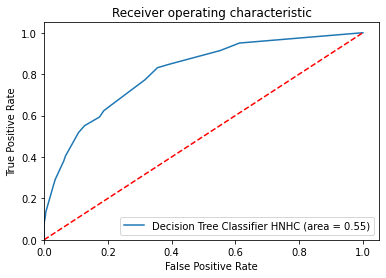

In [38]:
# Plotting the chart
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree Classifier HNHC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('images\Decision_Tree_Classifier_HNHC_ROC_5')
plt.show()

In [39]:
# K-Fold Validation using Decision Tree Classifier
scores = cross_validate(model, cleaned_data_wo_outcome_df, target_srs, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.023929,0.007978,0.797952,0.791009,0.800000,0.925234,0.057143,0.078447,0.966650,0.967615
1,0.017985,0.007979,0.798739,0.795396,0.863636,0.852174,0.135714,0.077655,0.969139,0.967339
2,0.016967,0.006973,0.766980,0.798815,1.000000,1.000000,0.050000,0.066561,0.966899,0.967422
3,0.018917,0.007945,0.802243,0.787464,0.818182,0.895652,0.064286,0.081616,0.966899,0.967615
4,0.015998,0.006308,0.770642,0.797179,0.666667,0.866142,0.057143,0.087163,0.966152,0.967671
5,0.021679,0.007142,0.766030,0.794119,0.923077,0.913462,0.085106,0.075337,0.967646,0.967505
6,0.019820,0.006948,0.778542,0.792829,0.857143,0.913462,0.085106,0.075337,0.967397,0.967505
7,0.017272,0.006952,0.780080,0.797343,0.666667,0.952381,0.042857,0.079239,0.965895,0.967727
8,0.016899,0.006962,0.804540,0.793084,1.000000,0.916667,0.085714,0.078447,0.968135,0.967588
9,0.017743,0.006982,0.745381,0.792300,0.818182,0.918182,0.064286,0.080032,0.966891,0.967644


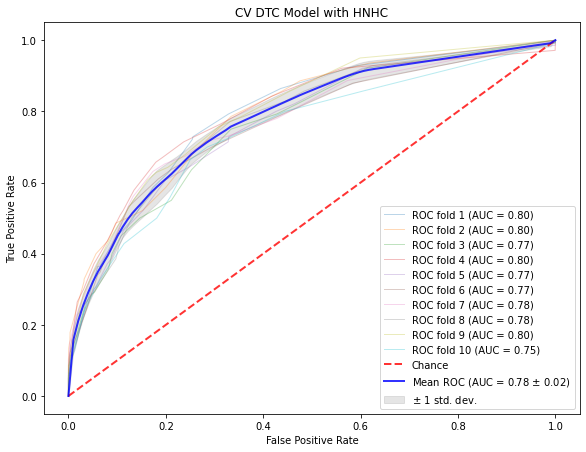

In [41]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
draw_cv_auc_roc(model, cv, cleaned_data_wo_outcome_df, target_srs, 'CV DTC Model with HNHC')

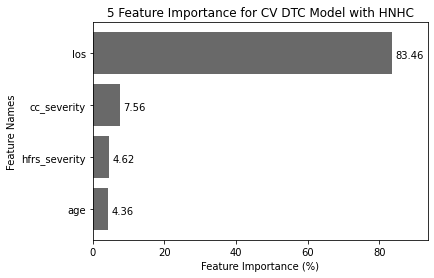

In [42]:
# Grab the feature importance using the cross validation Decision Tree Classifier model
importance = sorted(zip(model.feature_importances_*100, X_train))

# Graph feature importance for Decision Tree Classifier
value_labels = [x[0] for x in importance]
feature_names = [y[1] for y in importance]
plt.barh(feature_names, value_labels, color='dimgray')
for index, value in enumerate(value_labels):
    plt.text(value/value_labels[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels)+10))
plt.ylabel('Feature Names')
plt.title('5 Feature Importance for CV DTC Model with HNHC')
# plt.savefig('images\CV_Decision_Tree_Classifier_HNHC_Feature_Importance_5')
plt.show()

## XGBoost Classifier RFE - HNHC <a class="anchor" id="xgbchnhc"></a>

[Return to Table of Contents](#contents)

In [43]:
# Plug in the features found by the XGBClassifier RFE process on the 2013 NRD file and repeat the same steps.
# These are the features from XGBClassifier RFE NRD 2013: ['los', 'orproc', 'payer', 'cm_dmcx', 'chronic_pain']
data = readm_data_df[['hnhc_patients', 'los', 'cm_dmcx', 'chronic_pain']]
# Drop NaN's.
cleaned_data = data.dropna(axis='rows')
# Display data.
print(cleaned_data)
# Extract the target feature into a Panda Series.
target_srs = cleaned_data['hnhc_patients']
target_srs = target_feature.astype('int64')
# Create a Pandas dataframe without the target feature.
cleaned_data_wo_outcome_df = cleaned_data.drop('hnhc_patients', axis=1)

       hnhc_patients  los  cm_dmcx  chronic_pain
0                0.0  1.0      0.0           0.0
1                0.0  3.0      0.0           0.0
2                0.0  2.0      0.0           0.0
3                0.0  3.0      0.0           0.0
5                0.0  5.0      0.0           0.0
...              ...  ...      ...           ...
82384            0.0  7.0      0.0           0.0
82388            0.0  2.0      0.0           0.0
82393            0.0  0.0      0.0           0.0
82394            0.0  1.0      0.0           0.0
82400            0.0  3.0      0.0           0.0

[40177 rows x 4 columns]


In [44]:
# Initial model with XGBClassifier
model = XGBClassifier(random_state=42, verbosity = 0)
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_df, target_srs, random_state=42)
model.fit(X_train, y_train)
print(f'Training Score: {model.score(X_train, y_train)}')
print(f'Testing Score: {model.score(X_test, y_test)}')

Training Score: 0.9681069958847737
Testing Score: 0.966351418616227


In [45]:
# Creating ROC/AUC chart values
roc_auc = roc_auc_score(y_test.values, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:,1])

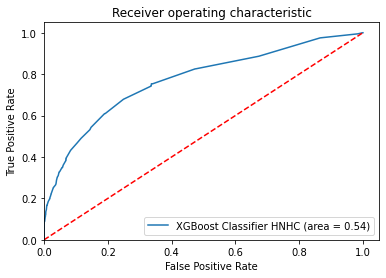

In [46]:
# Plotting the chart
plt.figure()
plt.plot(fpr, tpr, label='XGBoost Classifier HNHC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('images\XGBClassifier_HNHC_ROC_5')
plt.show()

In [47]:
# K-Fold Validation using XGBClassifier
scores = cross_validate(model, cleaned_data_wo_outcome_df, target_srs, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.489599,0.016853,0.749762,0.760829,0.750000,0.897638,0.064286,0.090333,0.966650,0.967892
1,0.484211,0.018804,0.774686,0.758247,0.772727,0.878049,0.121429,0.085578,0.968143,0.967671
2,0.491539,0.013426,0.723434,0.763570,0.727273,0.891473,0.057143,0.091125,0.966401,0.967892
3,0.510838,0.020839,0.777002,0.757871,0.857143,0.869231,0.085714,0.089540,0.967646,0.967754
4,0.502067,0.017952,0.714087,0.763794,0.916667,0.880000,0.078571,0.087163,0.967646,0.967726
5,0.499872,0.018931,0.732562,0.762588,1.000000,0.889831,0.085106,0.083267,0.967894,0.967671
6,0.500189,0.019566,0.757149,0.760078,0.769231,0.909091,0.070922,0.087232,0.966650,0.967864
7,0.498941,0.018819,0.762168,0.759775,0.666667,0.866667,0.057143,0.092710,0.966144,0.967837
8,0.505307,0.019544,0.772072,0.758264,0.857143,0.859375,0.085714,0.087163,0.967638,0.967644
9,0.489237,0.016954,0.769877,0.758842,0.785714,0.880000,0.078571,0.087163,0.967140,0.967727


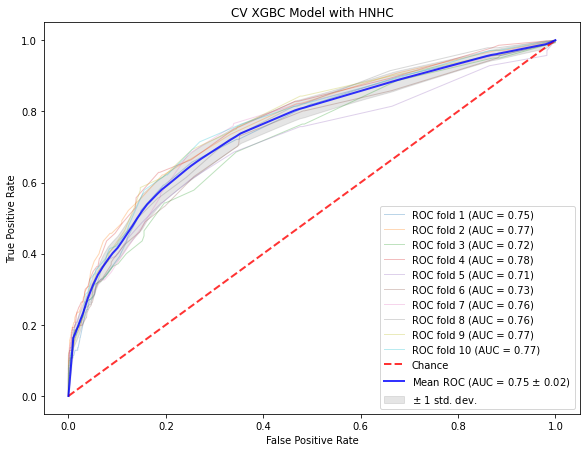

In [48]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model, cv, cleaned_data_wo_outcome_df, target_srs, 'CV XGBC Model with HNHC')

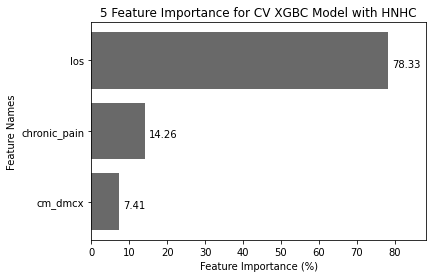

In [49]:
# Grab the feature importance using the cross validation XGBClassifier model
importance = sorted(zip(model.feature_importances_*100, X_train))

# Graph feature importance for XGBClassifier
value_labels = [x[0] for x in importance]
feature_names = [y[1] for y in importance]
fig, ax = plt.subplots()
ax.autoscale(enable=True) 
plt.barh(feature_names, value_labels, color='dimgray')
for index, value in enumerate(value_labels):
    plt.text(value/value_labels[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels)+10))
plt.ylabel('Feature Names')
plt.title('5 Feature Importance for CV XGBC Model with HNHC')
# plt.savefig('images\XGBClassifier_HNHC_Feature_Importance_5')
plt.show()

## Target: HNHC without 'los' <a class="anchor" id="hnhcwolos"></a> 

[Return to Table of Contents](#contents)

## Decision Tree Classifier RFE - HNHC without 'los' <a class="anchor" id="dtchnhcwolos"></a> 

[Return to Table of Contents](#contents)

In [52]:
# Plug in the features found by the DTC RFE process on the 2013 NRD file and repeat the same steps.
# These are the features from DTC RFE NRD 2013: ['age', 'orproc', 'severe_IBD_hospitalization', 'blood_transfusion', 'frailty_risk_score']
data = readm_data_df[['hnhc_patients', 'age', 'severe_ibd_hospitalization', 'blood_transfusion', 'hfrs_severity']]
# Drop NaN's.
cleaned_data = data.dropna(axis='rows')
# Display data.
print(cleaned_data)
# Extract the target feature into a Panda Series.
target_srs = cleaned_data['hnhc_patients']
target_srs = target_feature.astype('int64')
# Create a Pandas dataframe without the target feature.
cleaned_data_wo_outcome_df = cleaned_data.drop('hnhc_patients', axis=1)

       hnhc_patients   age  severe_ibd_hospitalization  blood_transfusion  \
0                0.0  88.0                         0.0                0.0   
1                0.0  49.0                         0.0                0.0   
2                0.0  63.0                         0.0                0.0   
3                0.0  54.0                         0.0                0.0   
5                0.0  83.0                         0.0                0.0   
...              ...   ...                         ...                ...   
82384            0.0  63.0                         1.0                0.0   
82388            0.0  25.0                         0.0                0.0   
82393            0.0  41.0                         0.0                0.0   
82394            0.0  63.0                         0.0                0.0   
82400            0.0  54.0                         0.0                1.0   

       hfrs_severity  
0                0.0  
1                0.0  
2     

In [53]:
# Initial model with Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42, splitter = "best", max_depth = 5)
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_df, target_srs, random_state=42)
model.fit(X_train, y_train)
print(f'Training Score: {model.score(X_train, y_train)}')
print(f'Testing Score: {model.score(X_test, y_test)}')

Training Score: 0.9655183857692818
Testing Score: 0.9639621702339473


In [54]:
# Creating ROC/AUC chart values
roc_auc = roc_auc_score(y_test.values, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:,1])

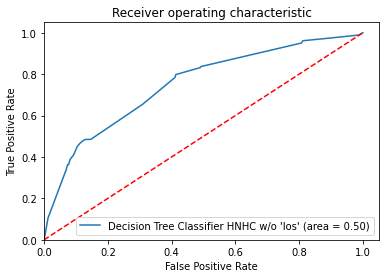

In [55]:
# Plotting the chart
plt.figure()
plt.plot(fpr, tpr, label="Decision Tree Classifier HNHC w/o 'los' (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('images\Decision_Tree_Classifier_no_los_HNHC_ROC_5')
plt.show()

In [56]:
# K-Fold Validation using Decision Tree Classifier
scores = cross_validate(model, cleaned_data_wo_outcome_df, target_srs, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.015960,0.008972,0.760190,0.764841,0.00,0.000000,0.000000,0.000000,0.965157,0.965099
1,0.013860,0.007542,0.748480,0.767234,0.00,0.000000,0.000000,0.000000,0.965157,0.965099
2,0.011938,0.007853,0.731654,0.769799,0.25,0.545455,0.007143,0.004754,0.964659,0.965126
3,0.012966,0.006984,0.779945,0.763825,0.00,0.000000,0.000000,0.000000,0.965157,0.965099
4,0.011999,0.003027,0.744557,0.767882,0.00,0.000000,0.000000,0.000000,0.965157,0.965099
5,0.011948,0.007398,0.721118,0.769575,0.00,0.000000,0.000000,0.000000,0.964908,0.965126
6,0.011683,0.008010,0.757065,0.766057,0.00,0.000000,0.000000,0.000000,0.964908,0.965126
7,0.016639,0.007202,0.746078,0.767670,0.00,0.000000,0.000000,0.000000,0.965148,0.965100
8,0.011475,0.007248,0.748825,0.767643,0.00,0.000000,0.000000,0.000000,0.965148,0.965100
9,0.010995,0.006841,0.740374,0.768329,0.00,0.000000,0.000000,0.000000,0.965148,0.965100


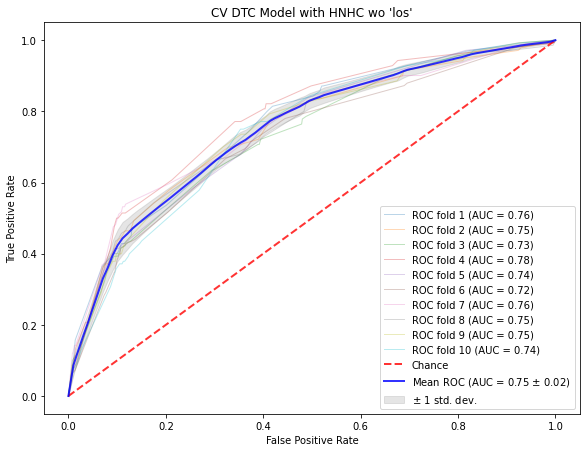

In [57]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model, cv, cleaned_data_wo_outcome_df, target_srs, "CV DTC Model with HNHC wo 'los'")

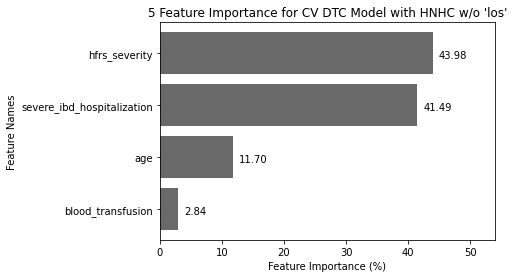

In [60]:
# Grab the feature importance using the cross validation Decision Tree Classifier model
importance = sorted(zip(model.feature_importances_*100, X_train))

# Graph feature importance for Decision Tree Classifier
value_labels = [x[0] for x in importance]
feature_names = [y[1] for y in importance]
plt.barh(feature_names, value_labels, color='dimgray')
for index, value in enumerate(value_labels):
    plt.text(value/value_labels[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels)+10))
plt.ylabel('Feature Names')
plt.title("5 Feature Importance for CV DTC Model with HNHC w/o 'los'")
# plt.savefig('images\CV_Decision_Tree_Classifier_HNHC_no_los_Feature_Importance_5')
plt.show()

## XGBoost Classifier RFE - HNHC without 'los' <a class="anchor" id="xgbchnhcwolos"></a>

[Return to Table of Contents](#contents)

In [62]:
# Plug in the features found by the XGBClassifier RFE process on the 2013 NRD file and repeat the same steps.
# These are the features from XGBClassifier RFE NRD 2013: ['orproc', 'payer', 'severe_IBD_hospitalization', 'cm_wghtloss', 'blood_transfusion']
data = readm_data_df[['hnhc_patients', 'severe_ibd_hospitalization', 'blood_transfusion']]
# Drop NaN's.
cleaned_data = data.dropna(axis='rows')
# Display data.
print(cleaned_data)
# Extract the target feature into a Panda Series.
target_srs = cleaned_data['hnhc_patients']
target_srs = target_feature.astype('int64')
# Create a Pandas dataframe without the target feature.
cleaned_data_wo_outcome_df = cleaned_data.drop('hnhc_patients', axis=1)

       hnhc_patients  severe_ibd_hospitalization  blood_transfusion
0                0.0                         0.0                0.0
1                0.0                         0.0                0.0
2                0.0                         0.0                0.0
3                0.0                         0.0                0.0
5                0.0                         0.0                0.0
...              ...                         ...                ...
82384            0.0                         1.0                0.0
82388            0.0                         0.0                0.0
82393            0.0                         0.0                0.0
82394            0.0                         0.0                0.0
82400            0.0                         0.0                1.0

[40177 rows x 3 columns]


In [63]:
# Initial model with XGBClassifier
model = XGBClassifier(random_state=42, verbosity = 0)
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_df, target_srs, random_state=42)
model.fit(X_train, y_train)
print(f'Training Score: {model.score(X_train, y_train)}')
print(f'Testing Score: {model.score(X_test, y_test)}')

Training Score: 0.9654520111509359
Testing Score: 0.9640617222498755


In [64]:
# Creating ROC/AUC chart values
roc_auc = roc_auc_score(y_test.values, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:,1])

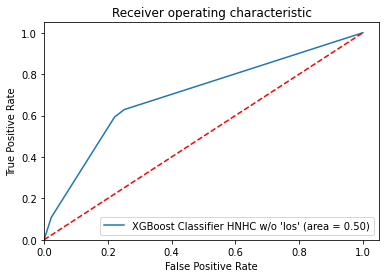

In [65]:
# Plotting the chart
plt.figure()
plt.plot(fpr, tpr, label="XGBoost Classifier HNHC w/o 'los' (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('images\XGBClassifier_HNHC_no_los_ROC_5')
plt.show()

In [66]:
# K-Fold Validation using XGBClassifier
scores = cross_validate(model, cleaned_data_wo_outcome_df, target_srs, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.204040,0.015833,0.698112,0.686573,0.0,0.0,0.0,0.0,0.965157,0.965099
1,0.198879,0.014860,0.715036,0.684666,0.0,0.0,0.0,0.0,0.965157,0.965099
2,0.199623,0.012964,0.670091,0.689669,0.0,0.0,0.0,0.0,0.965157,0.965099
3,0.199502,0.015122,0.704074,0.685874,0.0,0.0,0.0,0.0,0.965157,0.965099
4,0.201557,0.013952,0.656694,0.691164,0.0,0.0,0.0,0.0,0.965157,0.965099
5,0.194352,0.016824,0.676027,0.689002,0.0,0.0,0.0,0.0,0.964908,0.965126
6,0.199152,0.017140,0.694454,0.686968,0.0,0.0,0.0,0.0,0.964908,0.965126
7,0.197039,0.017042,0.690211,0.687438,0.0,0.0,0.0,0.0,0.965148,0.965100
8,0.203495,0.016985,0.684991,0.688016,0.0,0.0,0.0,0.0,0.965148,0.965100
9,0.201375,0.015859,0.687323,0.687741,0.0,0.0,0.0,0.0,0.965148,0.965100


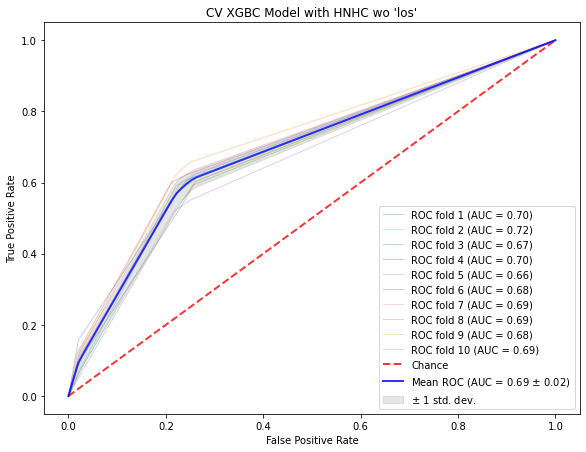

In [67]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model, cv, cleaned_data_wo_outcome_df, target_srs, "CV XGBC Model with HNHC wo 'los'")

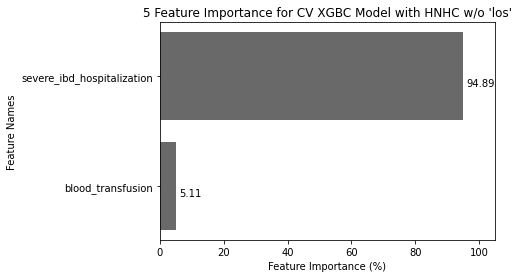

In [68]:
# Grab the feature importance using the cross validation XGBClassifier model
importance = sorted(zip(model.feature_importances_*100, X_train))

# Graph feature importance for XGBClassifier
value_labels = [x[0] for x in importance]
feature_names = [y[1] for y in importance]
fig, ax = plt.subplots()
ax.autoscale(enable=True) 
plt.barh(feature_names, value_labels, color='dimgray')
for index, value in enumerate(value_labels):
    plt.text(value/value_labels[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels)+10))
plt.ylabel('Feature Names')
plt.title("5 Feature Importance for CV XGBC Model with HNHC w/o 'los'")
# plt.savefig('images\XGBClassifier_HNHC_no_los_Feature_Importance_5')
plt.show()

## Target: IBD_READM <a class="anchor" id="ibd"></a> 

[Return to Table of Contents](#contents)

## Decision Tree Classifier RFE - IBD_READM <a class="anchor" id="dtcibd"></a> 

[Return to Table of Contents](#contents)

In [69]:
# Plug in the features found by the DTC RFE process on the 2013 NRD file and repeat the same steps.
# These are the features from DTC RFE NRD 2013: ['age', 'los', 'orproc', 'payer', 'cc_index']
data = readm_data_df[['ibd_readm', 'age', 'los', 'cc_severity']]
# Drop NaN's.
cleaned_data = data.dropna(axis='rows')
# Display data.
print(cleaned_data)
# Extract the target feature into a Panda Series.
target_srs = cleaned_data['ibd_readm']
target_srs = target_feature.astype('int64')
# Create a Pandas dataframe without the target feature.
cleaned_data_wo_outcome_df = cleaned_data.drop('ibd_readm', axis=1)

       ibd_readm   age  los  cc_severity
0            0.0  88.0  1.0          0.0
1            0.0  49.0  3.0          1.0
2            0.0  63.0  2.0          1.0
3            1.0  54.0  3.0          0.0
5            0.0  83.0  5.0          2.0
...          ...   ...  ...          ...
82384        1.0  63.0  7.0          2.0
82388        1.0  25.0  2.0          0.0
82393        0.0  41.0  0.0          1.0
82394        1.0  63.0  1.0          1.0
82400        1.0  54.0  3.0          0.0

[40177 rows x 4 columns]


In [70]:
# Initial model with Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42, splitter = "best", max_depth = 5)
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_df, target_srs, random_state=42)
model.fit(X_train, y_train)
print(f'Training Score: {model.score(X_train, y_train)}')
print(f'Testing Score: {model.score(X_test, y_test)}')

Training Score: 0.9678414974113899
Testing Score: 0.9657541065206571


In [71]:
# Creating ROC/AUC chart values
roc_auc = roc_auc_score(y_test.values, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:,1])

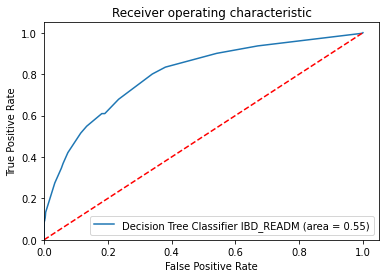

In [72]:
# Plotting the chart
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree Classifier IBD_READM (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('images\Decision_Tree_Classifier_IBD_READM_ROC_5')
plt.show()

In [73]:
# K-Fold Validation using Decision Tree Classifier
scores = cross_validate(model, cleaned_data_wo_outcome_df, target_srs, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.021699,0.009166,0.777018,0.788319,0.800000,0.925234,0.057143,0.078447,0.966650,0.967615
1,0.014959,0.007014,0.796217,0.786210,0.863636,0.852174,0.135714,0.077655,0.969139,0.967339
2,0.014978,0.008010,0.784051,0.788947,1.000000,1.000000,0.050000,0.066561,0.966899,0.967422
3,0.015922,0.008279,0.783320,0.785399,0.818182,0.896552,0.064286,0.082409,0.966899,0.967643
4,0.014887,0.006981,0.761043,0.788820,0.666667,0.866142,0.057143,0.087163,0.966152,0.967671
5,0.016405,0.006950,0.759902,0.790604,0.923077,0.913462,0.085106,0.075337,0.967646,0.967505
6,0.016212,0.006982,0.789770,0.786567,0.857143,0.913462,0.085106,0.075337,0.967397,0.967505
7,0.015989,0.006494,0.780904,0.787530,0.666667,0.952381,0.042857,0.079239,0.965895,0.967727
8,0.015958,0.006675,0.783129,0.788039,1.000000,0.916667,0.085714,0.078447,0.968135,0.967588
9,0.015810,0.006946,0.747870,0.790124,0.769231,0.897436,0.071429,0.083201,0.966891,0.967671


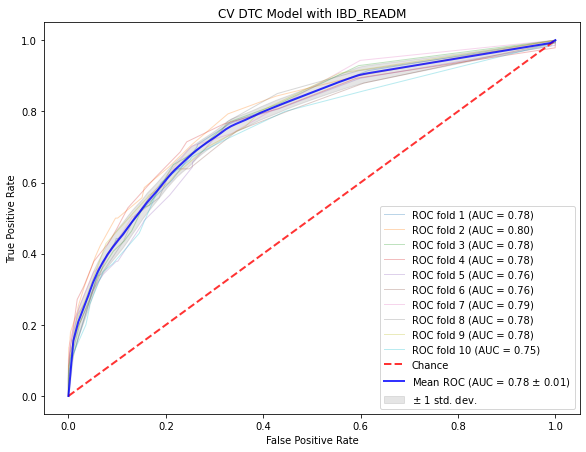

In [74]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model, cv, cleaned_data_wo_outcome_df, target_srs, 'CV DTC Model with IBD_READM')

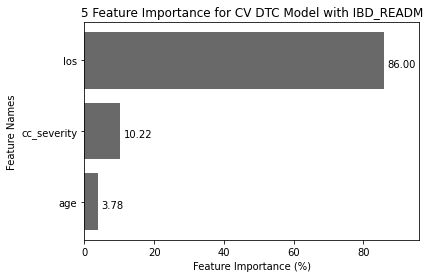

In [76]:
# Grab the feature importance using the cross validation Decision Tree Classifier model
importance = sorted(zip(model.feature_importances_*100, X_train))

# Graph feature importance for Decision Tree Classifier
value_labels = [x[0] for x in importance]
feature_names = [y[1] for y in importance]
plt.barh(feature_names, value_labels, color='dimgray')
for index, value in enumerate(value_labels):
    plt.text(value/value_labels[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels)+10))
plt.ylabel('Feature Names')
plt.title('5 Feature Importance for CV DTC Model with IBD_READM')
# plt.savefig('images\CV_Decision_Tree_Classifier_IBD_READM_Feature_Importance_5')
plt.show()

## XGBoost Classifier RFE - IBD_READM <a class="anchor" id="xgbcibd"></a>

[Return to Table of Contents](#contents)

In [78]:
# Plug in the features found by the XGBClassifier RFE process on the 2013 NRD file and repeat the same steps.
# These are the features from XGBClassifier RFE NRD 2013: ['elective', 'orproc', 'payer', 'ibd_procedures', 'ibd_specific_adm']
data = readm_data_df[['ibd_readm', 'elective']]
# Drop NaN's.
cleaned_data = data.dropna(axis='rows')
# Display data.
print(cleaned_data)
# Extract the target feature into a Panda Series.
target_srs = cleaned_data['ibd_readm']
target_srs = target_feature.astype('int64')
# Create a Pandas dataframe without the target feature.
cleaned_data_wo_outcome_df = cleaned_data.drop('ibd_readm', axis=1)

       ibd_readm  elective
0            0.0       1.0
1            0.0       0.0
2            0.0       0.0
3            1.0       0.0
5            0.0       0.0
...          ...       ...
82384        1.0       0.0
82388        1.0       0.0
82393        0.0       0.0
82394        1.0       0.0
82400        1.0       0.0

[40177 rows x 2 columns]


In [79]:
# Initial model with XGBClassifier
model = XGBClassifier(random_state=42, verbosity = 0)
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_df, target_srs, random_state=42)
model.fit(X_train, y_train)
print(f'Training Score: {model.score(X_train, y_train)}')
print(f'Testing Score: {model.score(X_test, y_test)}')

Training Score: 0.9654520111509359
Testing Score: 0.9640617222498755


In [80]:
# Creating ROC/AUC chart values
roc_auc = roc_auc_score(y_test.values, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:,1])

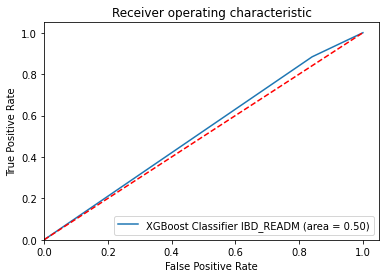

In [81]:
# Plotting the chart
plt.figure()
plt.plot(fpr, tpr, label='XGBoost Classifier IBD_READM (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('images\XGBClassifier_IBD_READM_ROC_5')
plt.show()

In [82]:
# K-Fold Validation using XGBClassifier
scores = cross_validate(model, cleaned_data_wo_outcome_df, target_srs, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.160491,0.018134,0.548182,0.529575,0.0,0.0,0.0,0.0,0.965157,0.965099
1,0.176196,0.016001,0.537726,0.530735,0.0,0.0,0.0,0.0,0.965157,0.965099
2,0.164814,0.014961,0.528043,0.531809,0.0,0.0,0.0,0.0,0.965157,0.965099
3,0.169055,0.013964,0.534631,0.531079,0.0,0.0,0.0,0.0,0.965157,0.965099
4,0.161991,0.012965,0.500980,0.534812,0.0,0.0,0.0,0.0,0.965157,0.965099
5,0.167552,0.012965,0.535794,0.530947,0.0,0.0,0.0,0.0,0.964908,0.965126
6,0.167365,0.012369,0.541339,0.530326,0.0,0.0,0.0,0.0,0.964908,0.965126
7,0.163519,0.015929,0.524929,0.532156,0.0,0.0,0.0,0.0,0.965148,0.965100
8,0.166056,0.015604,0.542697,0.530184,0.0,0.0,0.0,0.0,0.965148,0.965100
9,0.165263,0.009974,0.519929,0.532709,0.0,0.0,0.0,0.0,0.965148,0.965100


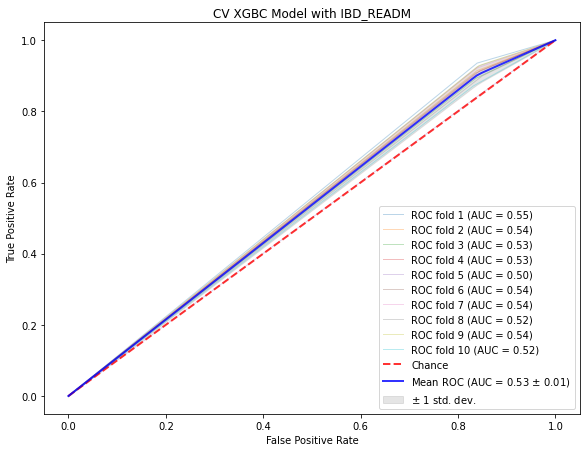

In [83]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model, cv, cleaned_data_wo_outcome_df, target_srs, 'CV XGBC Model with IBD_READM')

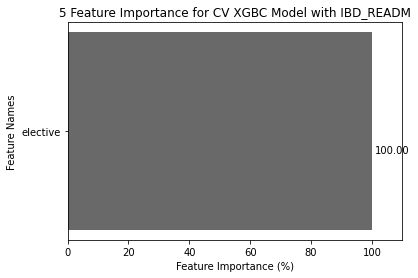

In [85]:
# Grab the feature importance using the cross validation XGBClassifier model
importance = sorted(zip(model.feature_importances_*100, X_train))

# Graph feature importance for XGBClassifier
value_labels = [x[0] for x in importance]
feature_names = [y[1] for y in importance]
fig, ax = plt.subplots()
ax.autoscale(enable=True) 
plt.barh(feature_names, value_labels, color='dimgray')
for index, value in enumerate(value_labels):
    plt.text(value/value_labels[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels)+10))
plt.ylabel('Feature Names')
plt.title('5 Feature Importance for CV XGBC Model with IBD_READM')
# plt.savefig('images\XGBClassifier_IBD_READM_Feature_Importance_5')
plt.show()

## Target: IBD_READM without 'los' <a class="anchor" id="ibdwolos"></a> 

[Return to Table of Contents](#contents)

## Decision Tree Classifier RFE - IBD_READM without 'los' <a class="anchor" id="dtcibdwolos"></a> 

[Return to Table of Contents](#contents)

In [86]:
# Plug in the features found by the DTC RFE process on the 2013 NRD file and repeat the same steps.
# These are the features from DTC RFE NRD 2013: ['age', 'orproc', 'payer', 'cc_index', 'frailty_risk_score']
data = readm_data_df[['ibd_readm', 'age', 'cc_severity', 'hfrs_severity']]
# Drop NaN's.
cleaned_data = data.dropna(axis='rows')
# Display data.
print(cleaned_data)
# Extract the target feature into a Panda Series.
target_srs = cleaned_data['ibd_readm']
target_srs = target_feature.astype('int64')
# Create a Pandas dataframe without the target feature.
cleaned_data_wo_outcome_df = cleaned_data.drop('ibd_readm', axis=1)

       ibd_readm   age  cc_severity  hfrs_severity
0            0.0  88.0          0.0            0.0
1            0.0  49.0          1.0            0.0
2            0.0  63.0          1.0            0.0
3            1.0  54.0          0.0            0.0
5            0.0  83.0          2.0            2.0
...          ...   ...          ...            ...
82384        1.0  63.0          2.0            1.0
82388        1.0  25.0          0.0            0.0
82393        0.0  41.0          1.0            0.0
82394        1.0  63.0          1.0            0.0
82400        1.0  54.0          0.0            0.0

[40177 rows x 4 columns]


In [87]:
# Initial model with Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42, splitter = "best", max_depth = 5)
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_df, target_srs, random_state=42)
model.fit(X_train, y_train)
print(f'Training Score: {model.score(X_train, y_train)}')
print(f'Testing Score: {model.score(X_test, y_test)}')

Training Score: 0.9655183857692818
Testing Score: 0.9639621702339473


In [88]:
# Creating ROC/AUC chart values
roc_auc = roc_auc_score(y_test.values, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:,1])

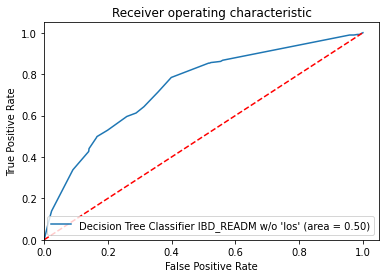

In [89]:
# Plotting the chart
plt.figure()
plt.plot(fpr, tpr, label="Decision Tree Classifier IBD_READM w/o 'los' (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('images\Decision_Tree_Classifier_IBD_READM_no_los_ROC_5')
plt.show()

In [90]:
# K-Fold Validation using Decision Tree Classifier
scores = cross_validate(model, cleaned_data_wo_outcome_df, target_srs, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.015970,0.009791,0.739938,0.744865,0.0,0.666667,0.000000,0.001585,0.964908,0.965126
1,0.013963,0.007979,0.718536,0.746456,1.0,1.000000,0.007143,0.003170,0.965406,0.965209
2,0.012964,0.007016,0.726902,0.745805,1.0,1.000000,0.007143,0.003170,0.965406,0.965209
3,0.013931,0.007293,0.758891,0.741472,0.0,0.533333,0.000000,0.006339,0.964659,0.965126
4,0.012977,0.006979,0.745209,0.744411,0.0,0.000000,0.000000,0.000000,0.965157,0.965099
5,0.013041,0.006978,0.723749,0.745795,0.0,0.000000,0.000000,0.000000,0.964908,0.965126
6,0.012633,0.008013,0.736191,0.743976,0.0,0.000000,0.000000,0.000000,0.964908,0.965126
7,0.012783,0.008019,0.716864,0.743093,0.0,1.000000,0.000000,0.003962,0.965148,0.965238
8,0.011762,0.006984,0.737040,0.743955,0.0,1.000000,0.000000,0.003962,0.965148,0.965238
9,0.012305,0.007978,0.683540,0.750647,0.0,0.666667,0.000000,0.001585,0.964899,0.965127


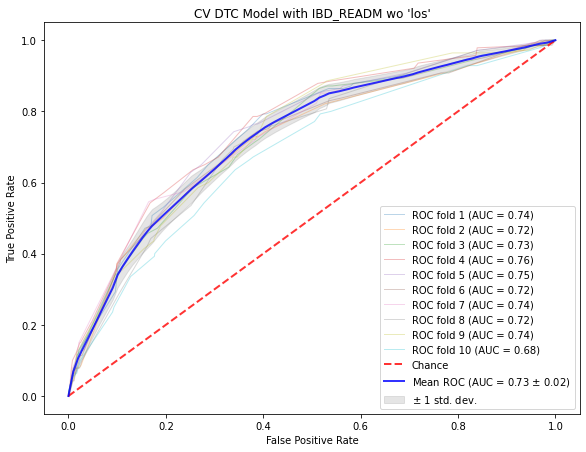

In [91]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model, cv, cleaned_data_wo_outcome_df, target_srs, "CV DTC Model with IBD_READM wo 'los'")

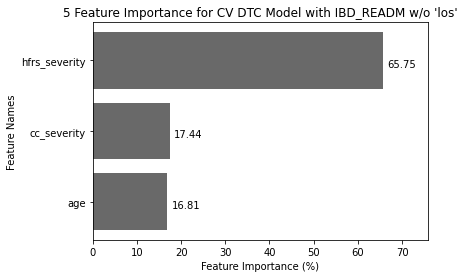

In [93]:
# Grab the feature importance using the cross validation Decision Tree Classifier model
importance = sorted(zip(model.feature_importances_*100, X_train))

# Graph feature importance for Decision Tree Classifier
value_labels = [x[0] for x in importance]
feature_names = [y[1] for y in importance]
plt.barh(feature_names, value_labels, color='dimgray')
for index, value in enumerate(value_labels):
    plt.text(value/value_labels[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels)+10))
plt.ylabel('Feature Names')
plt.title("5 Feature Importance for CV DTC Model with IBD_READM w/o 'los'")
# plt.savefig('images\CV_Decision_Tree_Classifier_IBD_READM_no_los_Feature_Importance_5')
plt.show()

## XGBoost Classifier Model - IBD_READM without 'los' <a class="anchor" id="xgbcibdwolos"></a>

[Return to Table of Contents](#contents)

In [94]:
# Plug in the features found by the XGBClassifier RFE process on the 2013 NRD file and repeat the same steps.
# These are the features from XGBClassifier RFE NRD 2013: ['orproc', 'payer', 'severe_IBD_hospitalization', 'cm_anemdef', 'chronic_pain']
data = readm_data_df[['ibd_readm', 'severe_ibd_hospitalization', 'chronic_pain']]
# Drop NaN's.
cleaned_data = data.dropna(axis='rows')
# Display data.
print(cleaned_data)
# Extract the target feature into a Panda Series.
target_srs = cleaned_data['ibd_readm']
target_srs = target_feature.astype('int64')
# Create a Pandas dataframe without the target feature.
cleaned_data_wo_outcome_df = cleaned_data.drop('ibd_readm', axis=1)

       ibd_readm  severe_ibd_hospitalization  chronic_pain
0            0.0                         0.0           0.0
1            0.0                         0.0           0.0
2            0.0                         0.0           0.0
3            1.0                         0.0           0.0
5            0.0                         0.0           0.0
...          ...                         ...           ...
82384        1.0                         1.0           0.0
82388        1.0                         0.0           0.0
82393        0.0                         0.0           0.0
82394        1.0                         0.0           0.0
82400        1.0                         0.0           0.0

[40177 rows x 3 columns]


In [95]:
# Initial model with XGBClassifier
model = XGBClassifier(random_state=42, verbosity = 0)
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_df, target_srs, random_state=42)
model.fit(X_train, y_train)
print(f'Training Score: {model.score(X_train, y_train)}')
print(f'Testing Score: {model.score(X_test, y_test)}')

Training Score: 0.9654520111509359
Testing Score: 0.9640617222498755


In [96]:
# Creating ROC/AUC chart values
roc_auc = roc_auc_score(y_test.values, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:,1])

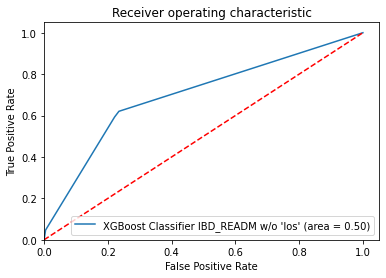

In [97]:
# Plotting the chart
plt.figure()
plt.plot(fpr, tpr, label="XGBoost Classifier IBD_READM w/o 'los' (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('images\XGBClassifier_IBD_READM_no_los_ROC_5')
plt.show()

In [98]:
# K-Fold Validation using XGBClassifier
scores = cross_validate(model, cleaned_data_wo_outcome_df, target_srs, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.194198,0.014931,0.683988,0.684416,0.0,0.0,0.0,0.0,0.965157,0.965099
1,0.205297,0.010847,0.700742,0.682555,0.0,0.0,0.0,0.0,0.965157,0.965099
2,0.194443,0.015030,0.661020,0.686963,0.0,0.0,0.0,0.0,0.965157,0.965099
3,0.198976,0.012967,0.703662,0.682238,0.0,0.0,0.0,0.0,0.965157,0.965099
4,0.202489,0.012773,0.661312,0.686935,0.0,0.0,0.0,0.0,0.965157,0.965099
5,0.198559,0.012844,0.667034,0.686320,0.0,0.0,0.0,0.0,0.964908,0.965126
6,0.193331,0.013878,0.685860,0.684206,0.0,0.0,0.0,0.0,0.964908,0.965126
7,0.194503,0.014737,0.678115,0.685059,0.0,0.0,0.0,0.0,0.965148,0.965100
8,0.200452,0.016823,0.705264,0.682049,0.0,0.0,0.0,0.0,0.965148,0.965100
9,0.202483,0.009974,0.696944,0.682976,0.0,0.0,0.0,0.0,0.965148,0.965100


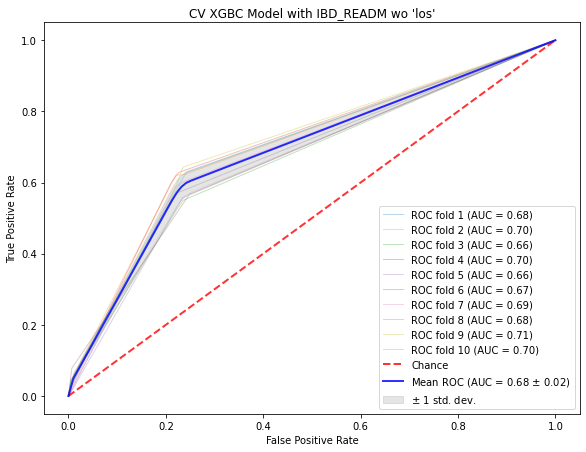

In [99]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model, cv, cleaned_data_wo_outcome_df, target_srs, "CV XGBC Model with IBD_READM wo 'los'")

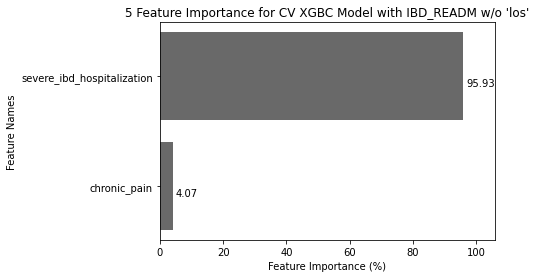

In [101]:
# Grab the feature importance using the cross validation XGBClassifier model
importance = sorted(zip(model.feature_importances_*100, X_train))

# Graph feature importance for XGBClassifier
value_labels = [x[0] for x in importance]
feature_names = [y[1] for y in importance]
fig, ax = plt.subplots()
ax.autoscale(enable=True) 
plt.barh(feature_names, value_labels, color='dimgray')
for index, value in enumerate(value_labels):
    plt.text(value/value_labels[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels)+10))
plt.ylabel('Feature Names')
plt.title("5 Feature Importance for CV XGBC Model with IBD_READM w/o 'los'")
# plt.savefig('images\XGBClassifier_IBD_READM_no_los_Feature_Importance_5')
plt.show()